# Prédire le futur avec python et tensorflow

## Introduction

Ce workshop a pour but de vous faire découvrir les réseaux LSTM (Long Short Term Memory) et de vous montrer comment les utiliser pour prédire des séries temporelles. Pour cela, nous allons utiliser la librairie TensorFlow (et Python, évidemment).

## Prérequis

Pour suivre ce workshop, vous aurez besoin de :

- Python 3 (le process d'installation de tensoflow est le plus simple avec python<3.13)
- TensorFlow (la version installée par défaut avec pip est suffisante)
- scikit-learn (pour normaliser les données)
- Jupyter Notebook (pour exécuter le code)
- Matplotlib (pour afficher les graphiques)
- Pandas (pour manipuler les données)
- Numpy (normalement installé automatiquement avec TensorFlow et/ou Pandas)

## Présentation des LSTM

Les LSTM sont une variante des réseaux de neurones récurrents (RNN) qui permettent de mieux gérer les dépendances temporelles dans les données. En effet, les RNN classiques ont tendance à "oublier" les premières données d'une séquence lorsqu'ils sont entraînés sur de longues séquences. Les LSTM permettent de conserver ces informations plus longtemps.

Les réseaux de neurones, de manière générale, sont composés de plusieurs couches de neurones. Chaque neurone est connecté à tous les neurones de la couche précédente et de la couche suivante. Les LSTM sont composés de plusieurs cellules LSTM, qui sont elles-mêmes composées de plusieurs portes (gates) qui permettent de contrôler le flux d'informations dans le réseau. Ces portes sont les suivantes :

- La porte d'oubli (forget gate) : permet de décider quelles informations garder et quelles informations oublier
- La porte d'entrée (input gate) : permet de décider quelles nouvelles informations ajouter à la cellule
- La porte de sortie (output gate) : permet de décider quelles informations envoyer à la couche suivante

Nous allons utiliser un réseau LSTM sur une série temporelle simple, mais ils ont de nombreuses applications, notamment dans le traitement du langage naturel, la traduction automatique, la génération de texte, etc.

Si vous avez un esprit un peu plus financier, vous voyez peut-être déjà où je veux en venir : les LSTM sont très utilisés pour prédire les cours de la bourse, car ils permettent de prendre en compte les dépendances temporelles dans les données. C'est ce que nous allons faire dans ce workshop.

## Préparation des données

Dans ce repository, vous allez pouvoir trouver plusieurs fichiers CSV contenant des données de cours de différentes cryptomonnaies. Nous allons utiliser ces données pour entraîner notre réseau LSTM et prédire les cours futurs. Choisissez le fichier que vous préférez, cela nous permettra de comparer nos résultats à la fin.

Tous ces fichiers ont été extraits de Binance, et sont donc des données réelles. Vous pouvez également utiliser vos propres données, si vous préférez le trading en bourse par exemple.

Nous allons commencer par importer les librairies, les données et les afficher pour voir à quoi elles ressemblent.


In [29]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler

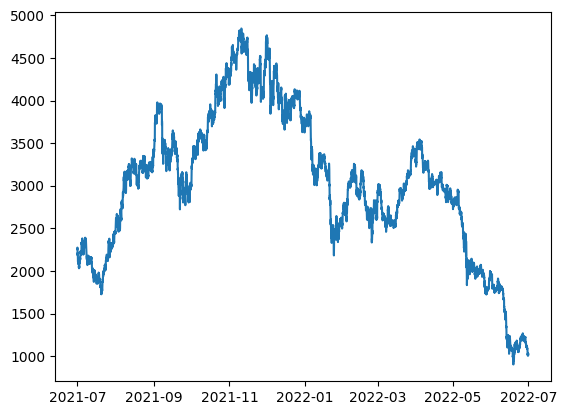

In [30]:
data = pd.read_csv('ethusdt.csv')
data = data.dropna()
data['Open Time'] = pd.to_datetime(data['Open Time'])
data = data.set_index('Open Time')
data = data.sort_index()

plt.plot(data['Close'])
plt.show()

## Définition des paramètres pour l'entraînement du modèle

Ici, nous définissons le set de paramètres à utiliser pour entraîner le modèle. Cela comprend les colonnes "features", utilisées pour établir une prédiction, mais aussi les paramètres du modèle LSTM tels que le nombre d'époques, la taille de fenêtre, ainsi que la répartition des données en training et en test.

In [31]:
date_column = "Open Time"        # Column name for dates (if applicable)
features = ["Open", "High", "Low", "Close", "Volume"]  # Feature columns to use
target_column = "Close"     # The target we want to predict (e.g. next closing price)
window_length = 60          # Number of past time steps to include in each input sample
batch_size = 32
epochs = 20
train_split = 0.8

## Normalisation (scaling) des données

Les LSTM sont sensibles à l'échelle des données. Il est donc important de normaliser les données avant de les passer au modèle.

Cela nous permet d'éviter de déstabiliser le modèle avec des valeurs trop grandes ou trop petites, et de faciliter la convergence de l'algorithme d'optimisation.

Nous allons utiliser un scaler de la librairie scikit-learn pour normaliser les données entre 0 et 1. Cela permet de faciliter la convergence de l'algorithme d'optimisation et d'éviter de déstabiliser le modèle avec des valeurs trop grandes ou trop petites.

Cela fait partie de paramètres à optimiser pour améliorer les performances du modèle.

In [32]:
data = data[features].dropna()
data_values = data.values
scaler = StandardScaler() # possible d'utiliser MinMaxScaler() ou RobustScaler()
scaled_data = scaler.fit_transform(data_values)
target_index = features.index(target_column)
target_data = scaled_data[:, target_index]

## Création des séquences

Les LSTM prennent en entrée des séquences de données. Nous allons donc créer des séquences de données à partir de notre série temporelle. Pour cela, nous allons utiliser une fenêtre de taille "window_length" pour créer des séquences de données.

Tout d'abord, nous devons nous assurer d'avoir assez de données pour créer des séquences de la taille souhaitée.

Ce premier bloc de code nous permet de créer les datasets pour l'entraînement et le test.

In [33]:
total_samples = len(scaled_data)
train_size = int(total_samples * train_split)

train_data = scaled_data[:train_size]
train_targets = target_data[:train_size]

test_data = scaled_data[train_size - window_length:]
test_targets = target_data[train_size - window_length:]

Ici, nous allons utiliser des fonctions de TensorFlow pour créer des datasets à partir de nos données.

Ces fonctions nous permettent de créer nos "fenêtres" (batches), et de venir accoler directement la target à chaque batch. Cela nous permet de ne pas avoir à gérer les indices de manière manuelle, et de venir directement entraîner notre modèle sur ces données.

In [34]:
train_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    data=train_data,
    targets=train_targets,
    sequence_length=window_length,
    sequence_stride=1,
    shuffle=True,
    batch_size=batch_size,
)

test_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    data=test_data,
    targets=test_targets,
    sequence_length=window_length,
    sequence_stride=1,
    shuffle=False,
    batch_size=batch_size,
)

## Création du modèle LSTM

Une fois nos données préparées, nous pouvons créer notre modèle LSTM.

TensorFlow propose une API très simple pour créer des modèles de réseaux de neurones. Nous allons utiliser la classe Sequential pour créer notre modèle.

Ce modèle (très simple) est composé de deux couches LSTM, suivies de quelques couches Dense pour la prédiction.

Nous allons utiliser la fonction compile pour définir la fonction de coût (loss) et l'optimiseur à utiliser pour entraîner le modèle.

Tout comme le scaler, ce sont des paramètres optimisables pour obtenir le meilleur modèle possible.

Vous pouvez également constater que la première couche est paramétrée en fonction de la taille de la fenêtre et du nombre de features. Cela permet de définir la taille de l'entrée du modèle.

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(window_length, len(features))),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer="adam", loss="mse")

# Display the model summary
model.summary()


C:\Users\natan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 60, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,937 (124.75 KB)

 Trainable params: 31,937 (124.75 KB)

 Non-trainable params: 0 (0.00 B)

## Entraînement du modèle

Nous pouvons maintenant entraîner notre modèle sur les données préparées auparavant.

Pour cela, nous utilisons la fonction fit de notre modèle, en lui passant les données d'entraînement et de validation.

Ici, ceux bénéficiant d'une carte graphique Nvidia peuvent donner leur facture d'électricité en offrande aux dieux CUDA pour accélérer le processus.

In [36]:
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=test_dataset
)

Epoch 1/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.1201 - val_loss: 0.2378
Epoch 2/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0321 - val_loss: 0.2288
Epoch 3/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0185 - val_loss: 0.1445
Epoch 4/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0059 - val_loss: 0.1636
Epoch 5/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0051 - val_loss: 0.1230
Epoch 6/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0074 - val_loss: 0.1027
Epoch 7/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0054 - val_loss: 0.1107
Epoch 8/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0024 - val_loss: 0.0984
Epoch 9/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 3606s 22ms/step - loss: 0.0024 - val_loss: 0.0989
Epoch 10/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0018 - val_loss: 0.0958
Epoch 11/20
218/218 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0014 - val_loss: 0.0971
Epoch 12/20
218/218 ━━━━━━━━━━━━━━━━━━

## Analyse de l'historique d'entraînement

Une fois le modèle entraîné, nous pouvons analyser l'historique d'entraînement pour voir comment le modèle a évolué au fil des époques.

Nous allons afficher les courbes de la fonction de coût (loss) pour l'entraînement et la validation.

Cela nous permet de voir si le modèle a convergé, et si nous avons besoin de modifier les paramètres d'entraînement.

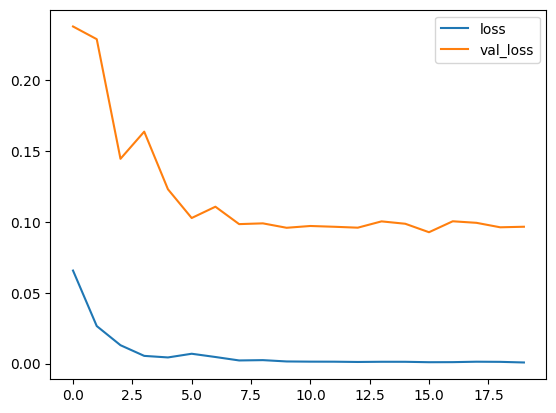

In [38]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
plt.show()

## Evaluation des capacités prédictives du modèle

Une fois le modèle entraîné, nous pouvons l'évaluer sur les données de test.

Pour cela, nous utilisons la fonction predict de notre modèle pour obtenir les prédictions sur les données de test.

Nous pouvons ensuite comparer ces prédictions aux vraies valeurs pour évaluer les performances du modèle.

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


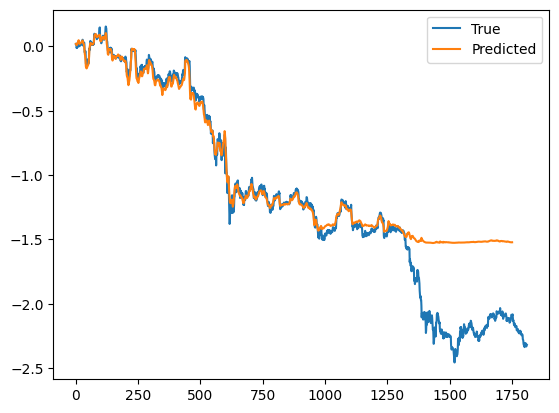

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
Predictions: [0.02054704 0.0180084  0.01492778 0.00951407 0.0127287 ]
Actual    : [ 0.01811119  0.0159482   0.02195136 -0.01185834 -0.00182994]


In [37]:
predictions = model.predict(test_dataset)

plt.plot(test_targets, label="True")
plt.plot(predictions, label="Predicted")
plt.legend()
plt.show()

for batch in test_dataset.take(1):
    inputs, targets = batch
    preds = model.predict(inputs)
    print("Predictions:", preds.flatten()[:5])
    print("Actual    :", targets.numpy().flatten()[:5])

## Analyse des résultats

Nous pouvons voir que le modèle se débrouille plutôt bien pour prédire les cours. Les prédictions semblent suivre la tendance générale des données, même si elles ne sont pas parfaites.

Il est possible d'améliorer les performances du modèle en ajustant les paramètres, en ajoutant des features, en changeant l'architecture du modèle, etc.

Nous utilisons ici un modèle très simple pour des raisons d'efficacité et aussi afin de ne pas passer des heures sur l'entraînement, mais il est possible d'obtenir de bien meilleurs résultats avec des modèles plus complexes.

## Possibles améliorations

Il existe de nombreuses façons d'améliorer les performances du modèle :

- Ajouter des features : nous avons utilisé uniquement des features basiques pour prédire les cours, mais il est possible d'ajouter d'autres features, notemment des indicateurs techniques (SMA, RSI, etc...).

- Optimiser les paramètres : nous avons utilisé des paramètres simples ou par défaut pour entraîner le modèle, mais il est possible d'optimiser ces paramètres pour obtenir de meilleurs résultats. Cela peut se faire en utilisant des techniques d'optimisation comme la recherche par grille, la recherche bayésienne, etc.

- Utiliser un modèle plus complexe : nous avons utilisé un modèle LSTM très simple, mais il est possible d'utiliser des modèles plus complexes comme les réseaux de neurones convolutifs (CNN), les réseaux de neurones récurrents bidirectionnels (BiLSTM), etc.

- Utiliser des techniques de régularisation : pour éviter le surapprentissage, il est possible d'utiliser des techniques de régularisation comme le dropout, la normalisation par lots, etc.

N'hésitez pas à essayer certaines de ces techniques et à partager vos découvertes !

## Conclusion

Les LSTM sont un outil puissant pour prédire des séries temporelles. Ils permettent de prendre en compte les dépendances temporelles dans les données et de faire des prédictions plus précises. Ce sont également des modèles relativement simples à mettre en place, ce qui en fait un bon choix pour du prototypage rapide.